This notebook demonstrates customer segmentation using two clustering techniques: **KMeans** and **MiniBatchKMeans**. We'll walk through every preprocessing and modeling step from scratch using a small sample of mall customer data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

**Load Dataset**

We start with a small dataset of 5 customers. The features include:

- `CustomerID`
- `Gender`
- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`

In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Encode Categorical Column**

The `Gender` column contains categorical values (`Male`, `Female`). We convert it into numeric form using **Label Encoding**:
- Male → 1
- Female → 0

This makes it usable for distance-based algorithms like KMeans.

In [3]:
le = LabelEncoder()
df['GenderEncoded'] = le.fit_transform(df['Gender'])
print(df[['Gender', 'GenderEncoded']])

     Gender  GenderEncoded
0      Male              1
1      Male              1
2    Female              0
3    Female              0
4    Female              0
..      ...            ...
195  Female              0
196  Female              0
197    Male              1
198    Male              1
199    Male              1

[200 rows x 2 columns]


**Feature Selection**

We select the following columns for clustering:

- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`
- `GenderEncoded`

These features represent key behavioral and demographic traits of each customer.


In [4]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'GenderEncoded']]

**Feature Scaling**

We apply **StandardScaler** to normalize the features.

Why?  
Because KMeans is sensitive to feature scale. If features like income and age are on different scales, clustering will be biased.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_scaled[:10]

array([[-1.42456879, -1.73899919, -0.43480148,  1.12815215],
       [-1.28103541, -1.73899919,  1.19570407,  1.12815215],
       [-1.3528021 , -1.70082976, -1.71591298, -0.88640526],
       [-1.13750203, -1.70082976,  1.04041783, -0.88640526],
       [-0.56336851, -1.66266033, -0.39597992, -0.88640526],
       [-1.20926872, -1.66266033,  1.00159627, -0.88640526],
       [-0.27630176, -1.62449091, -1.71591298, -0.88640526],
       [-1.13750203, -1.62449091,  1.70038436, -0.88640526],
       [ 1.80493225, -1.58632148, -1.83237767,  1.12815215],
       [-0.6351352 , -1.58632148,  0.84631002, -0.88640526]])

**Elbow Method**

Before running KMeans, we determine the optimal number of clusters using the **Elbow Method**:

1. Run KMeans for `k = 1` to `k = 30`
2. Track the **inertia** (sum of squared distances to nearest centroid)
3. Plot `k` vs `inertia`
4. The "elbow" point in the graph is the optimal value for `k`

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

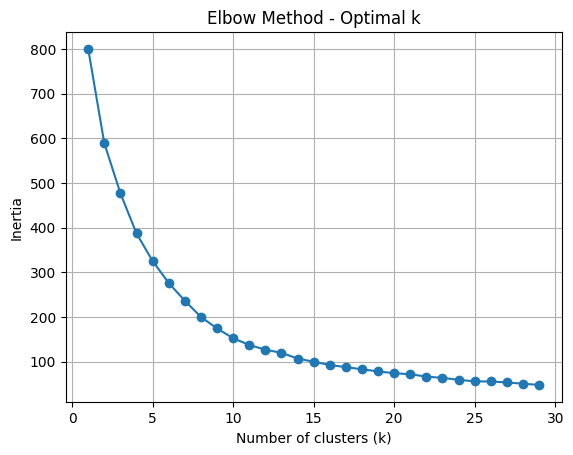

In [10]:
inertia = []
K_range = range(1, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Optimal k')
plt.grid(True)
plt.show()

**KMean Clustering**

We apply `KMeans(n_clusters=k)` with the optimal value of `k` found from the elbow method (e.g., 3).  
Each customer is assigned a cluster label based on feature similarity.

In [11]:
# optimal clusters based on elbow method
optimal_k = 25  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
print(df[['CustomerID', 'KMeans_Cluster']])


     CustomerID  KMeans_Cluster
0             1               9
1             2              14
2             3              13
3             4              10
4             5              13
..          ...             ...
195         196              16
196         197               7
197         198              23
198         199              21
199         200              23

[200 rows x 2 columns]


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**MiniBatchKMeans Clustering**

We repeat the clustering using **MiniBatchKMeans** — a faster version that works on small random batches of data.

- Suitable for large-scale or streaming data
- Slightly less accurate but much faster than regular KMeans

In [12]:
mbkmeans = MiniBatchKMeans(n_clusters=25, batch_size=2, random_state=42)
mbk_labels = mbkmeans.fit_predict(X_scaled)
df['MiniBatch_Cluster'] = mbk_labels
print(df)

     CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0             1    Male   19                  15                      39   
1             2    Male   21                  15                      81   
2             3  Female   20                  16                       6   
3             4  Female   23                  16                      77   
4             5  Female   31                  17                      40   
..          ...     ...  ...                 ...                     ...   
195         196  Female   35                 120                      79   
196         197  Female   45                 126                      28   
197         198    Male   32                 126                      74   
198         199    Male   32                 137                      18   
199         200    Male   30                 137                      83   

     GenderEncoded  KMeans_Cluster  MiniBatch_Cluster  
0                1             

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Cluster Visualization**

We plot the results of both KMeans and MiniBatchKMeans side-by-side using `Annual Income` and `Spending Score` (scaled) as X and Y axes.

- Points are colored by cluster labels
- Cluster centers are shown with red or black X markers


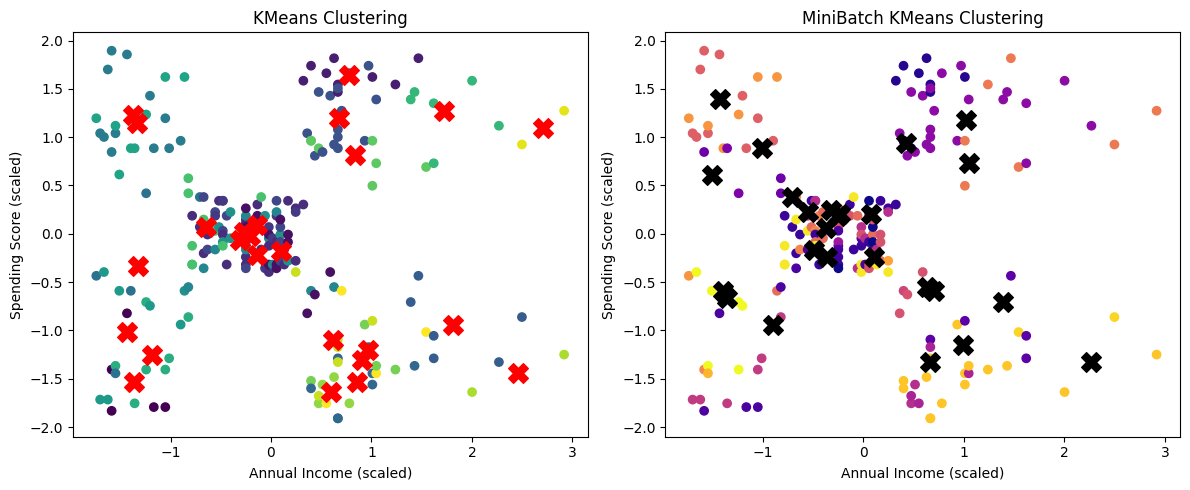

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KMeans plot
axes[0].scatter(X_scaled[:, 1], X_scaled[:, 2], c=df['KMeans_Cluster'], cmap='viridis')
axes[0].scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', s=200, marker='X')
axes[0].set_title("KMeans Clustering")
axes[0].set_xlabel("Annual Income (scaled)")
axes[0].set_ylabel("Spending Score (scaled)")

# MiniBatchKMeans plot
axes[1].scatter(X_scaled[:, 1], X_scaled[:, 2], c=df['MiniBatch_Cluster'], cmap='plasma')
axes[1].scatter(mbkmeans.cluster_centers_[:, 1], mbkmeans.cluster_centers_[:, 2], c='black', s=200, marker='X')
axes[1].set_title("MiniBatch KMeans Clustering")
axes[1].set_xlabel("Annual Income (scaled)")
axes[1].set_ylabel("Spending Score (scaled)")

plt.tight_layout()

This notebook demonstrates how to segment mall customers based on key features using clustering. This approach can help marketing teams create targeted campaigns and personalized offers.